This project involves building a recommendation system based on two models

1. User features similarity (i.e if a user has a similar features like skin type, tone, eye color, hair color with another user, then probably th ey might enjoy same products)
2. Content-based recommendations (cosine similarity between the chemical compositions of the products)

Let's first start my importing all neccesary libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from bokeh.io import show, curdoc, output_notebook, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnarDataSource, HoverTool, Select, Paragraph, TextInput
from bokeh.layouts import column, row
from ipywidgets import interact

from nltk.probability import FreqDist
from nltk.corpus import stopwords
from matplotlib import cm

import markovify
import string

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.pipeline import Pipeline

from sklearn.naive_bayes  import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

import warnings; warnings.simplefilter('ignore')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/ama/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ama/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [61]:
data = pd.read_csv('../Datasets/skindataall.csv', index_col=[0])

In [54]:
data.head(5)

,Username,Skin_Tone,Skin_Type,Eye_Color,Hair_Color,Rating_Stars,Review,Product,Brand,Price,...,Oily,Sensitive,Category,Product_Url,User_id,Product_id,Ingredients_Cleaned,Review_Cleaned,Good_Stuff,Ing_Tfidf
0,allyp3,Medium,Combination,Brown,Brunette,5,This is hands down the best cleanser I’ve ever...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,3420,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['hand', 'best', 'cleanser', 'ever', 'used', '...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
1,PatTea,Medium,Combination,Brown,Red,1,Unfortunately this doesn’t work for everyone. ...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2483,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['unfortunately', 'work', 'everyone', 'used', ...",0,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
2,Sabi1991,No data,No data,No data,No data,5,My favorite cleanser!! i love the packaging on...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,2715,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['favorite', 'cleanser', 'love', 'packaging', ...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
3,happyface2,Fair,Dry,Blue,Blonde,5,I love all things Youth To The People! This cl...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,4497,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['love', 'thing', 'youth', 'people', 'cleanser...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."
4,kimkix34,Fair,Normal,Green,Blonde,5,I had a trial size of this and was obsessed. M...,Superfood Antioxidant Cleanser,YOUTH TO THE PEOPLE,36,...,0,0,Cleanser,https://www.sephora.com/product/kale-spinach-g...,5017,157,"['sodium', 'cocoyl', 'glutamate', 'cocamidopro...","['trial', 'size', 'wa', 'obsessed', 'skin', 'f...",1,"sodium, cocoyl, glutamate, cocamidopropyl, bet..."


<Axes: xlabel='Skin_Tone'>

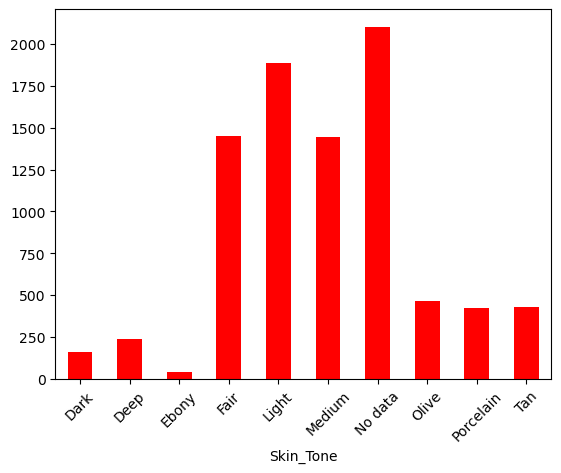

In [4]:
skintone_stats = data.groupby('Skin_Tone')['Username'].count()
skintone_stats.plot.bar(color='red', rot=45)

<Axes: xlabel='Skin_Type'>

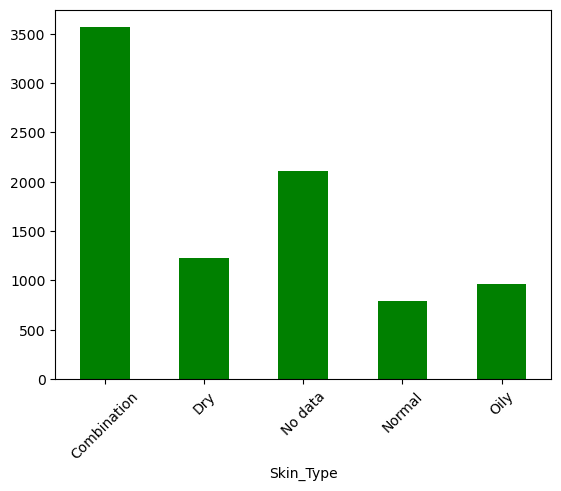

In [37]:
skintone_stats = data.groupby('Skin_Type')['Username'].count()
skintone_stats.plot.bar(color='green', rot=45)

<Axes: xlabel='Eye_Color'>

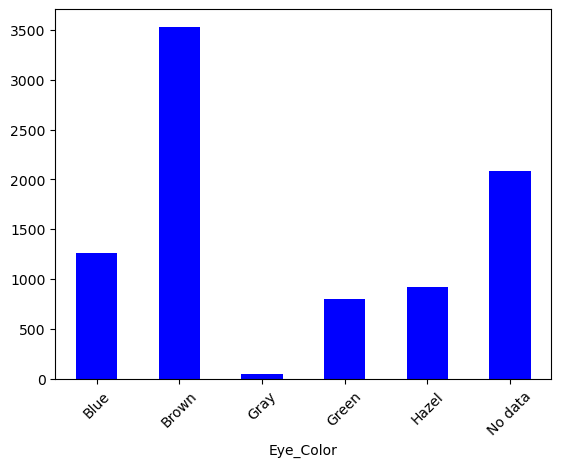

In [6]:
eyecolor_stats = data.groupby('Eye_Color')['Username'].count()
eyecolor_stats.plot.bar(color='blue', rot=45)

<Axes: xlabel='Hair_Color'>

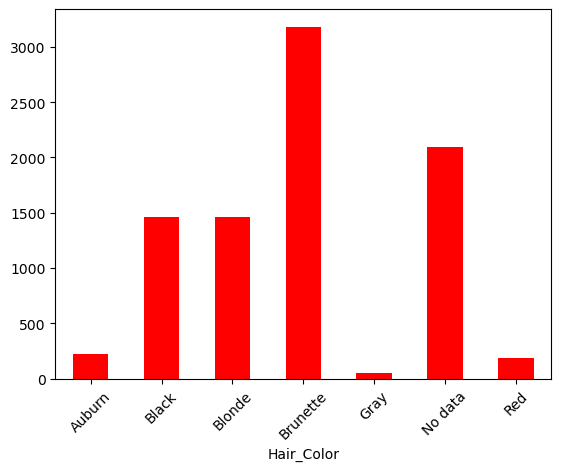

In [7]:
haircolor_stats = data.groupby('Hair_Color')['Username'].count()
haircolor_stats.plot.bar(color='red', rot=45)

<Axes: xlabel='Rating_Stars'>

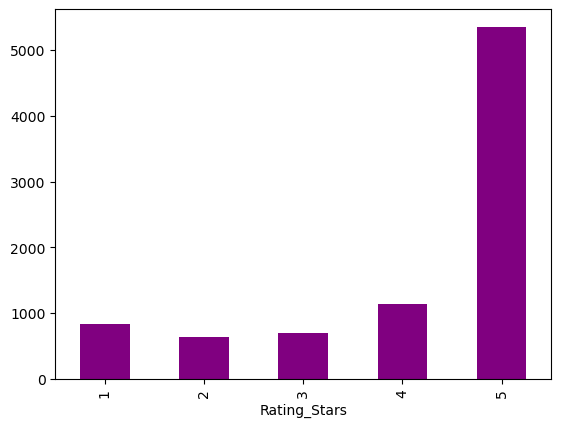

In [8]:
rating_stats = data.groupby('Rating_Stars')['Username'].count()
rating_stats.plot.bar(color='purple')

From the graph above the ratings are unevenly distributed. We observe that the 5-star is more dorminant and with the 1 - 4 star ratings having a low frequency count. 

### Markov Chain neural net for langauge generator

In [9]:
import markovify
import string

In [10]:
def no_punct(string):
    no_punct_string = re.sub(r'[^\w\s]', '', string)
    return no_punct_string

In [11]:
data['Review'] = data.apply(lambda row: no_punct(row['Review']), axis=1)

In [12]:
text_model = markovify.NewlineText(data.Review, state_size=2)

In [13]:
for i in range(3):
    print(text_model.make_sentence())

The best make up removers and none have changed every skincare product I absolutely love this product I have ever used I highly suggest keeping your routine saving it for a few uses his face with this product and Ive had acne and this one I will see a difference within a week or every other day This is the 2nd time I use a less expensive moisturizers and have 4 bottlesIm so I really need just a few months ago I gave it the worse without it My skin has responded so well without stripping it
I have always struggled to find a cleaner that gets dryer in the morning my skin out I have a hard time finding a product that caused so much love for this After 12 weeks Ive noticed a huge fan of this and have not found one that doesnt completely remove your makeup rinses off clean and fresh it helps keep are faces clear and significantly less noticeable Im obsessed Ive been using this mask for 10 years younger Just a bit unpleasant I also had a really nice and minty
Hydrating and refreshing but als

### NLP: wordclouds and classification

In [14]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [15]:
negative_data = data[data.Rating_Stars <= 4]
positive_data = data[data.Rating_Stars > 4]
negative = " ".join(review for review in negative_data.Review)
positive = " ".join(review for review in positive_data.Review)

In [16]:
stopwords = set(STOPWORDS)
stopwords.update(['read', 'more', 'product'])

In [17]:
def generate_wordcloud(data):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(data)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

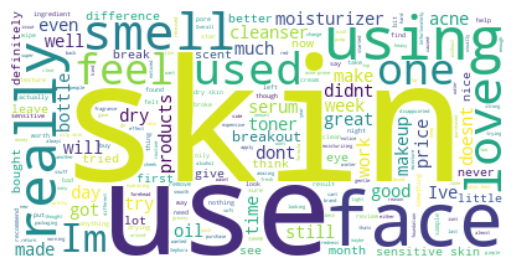

In [18]:
generate_wordcloud(negative)

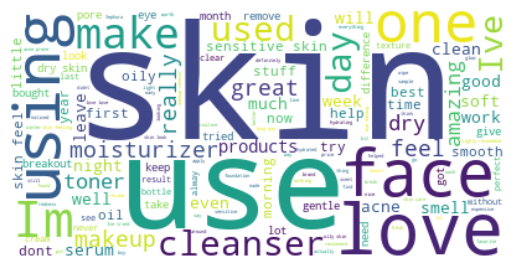

In [19]:
generate_wordcloud(positive)

Looking at wordcloud of negative reviews, you can see that a lot of people have a negative smell, complain about their face. 

We would proceed the ingredients of skincare products. Knowing very little on chemistry, let's proceed to distinguish between categories, such as serum

In [20]:
moist_data = data[data.Category == 'Moisturizer']
cleanse_data = data[data.Category == 'Cleanser']
mask_data = data[data.Category == 'Face Mask']
treat_data = data[data.Category == 'Treatment']

In [21]:
moist = ' '.join(ing for ing in moist_data.Ingredients)
cleanse = ' '.join(ing for ing in cleanse_data.Ingredients)
mask = ' '.join(ing for ing in mask_data.Ingredients)
treat = ' '.join(ing for ing in treat_data.Ingredients)

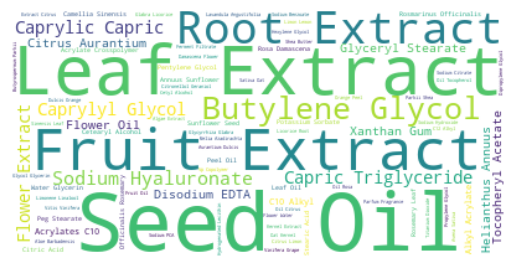

In [22]:
generate_wordcloud(moist)

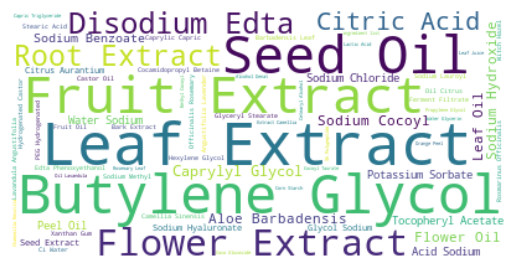

In [23]:
generate_wordcloud(cleanse)

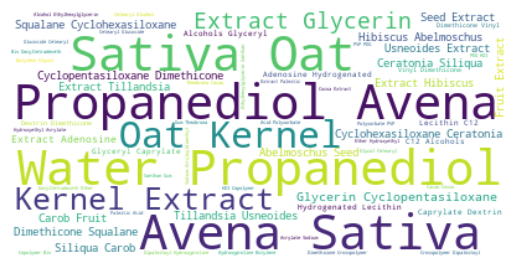

In [24]:
generate_wordcloud(mask)

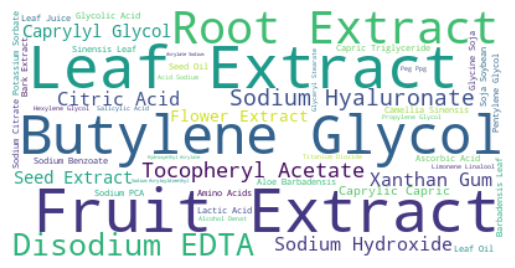

In [25]:
generate_wordcloud(treat)

We would proceed to build classification model to distinguish the products.

In [26]:
X = data.Ingredients
y = data.Category

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [27]:
categories = ['Moisturizer', 'Cleanser', 'Face Mask', 'Treatment']

#### Naive Bayes

In [28]:
nb = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])

nb.fit(X_train, y_train)

y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=categories))

accuracy 0.9653259361997226
              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



#### Logistic Regression

In [29]:
logreg = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression(n_jobs=1, C=1e5))
])

logreg.fit(X_train, y_train)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=categories))

accuracy 0.9653259361997226
              precision    recall  f1-score   support

 Moisturizer       0.96      0.99      0.98      1031
    Cleanser       0.00      0.00      0.00         9
   Face Mask       0.99      0.96      0.98       649
   Treatment       0.94      0.92      0.93       474

    accuracy                           0.97      2163
   macro avg       0.72      0.72      0.72      2163
weighted avg       0.96      0.97      0.96      2163



#### SVG with SGD

In [30]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=categories))

accuracy 0.9754969949144706
              precision    recall  f1-score   support

 Moisturizer       0.99      0.97      0.98      1031
    Cleanser       1.00      1.00      1.00         9
   Face Mask       0.96      1.00      0.98       649
   Treatment       0.97      0.96      0.96       474

    accuracy                           0.98      2163
   macro avg       0.98      0.98      0.98      2163
weighted avg       0.98      0.98      0.98      2163



### Latent Dirichlet Allocation

Now that w ehave different skincare categories would be distinguishable, we would proceed to do unsupervised clusstgering to figure out how the ingredients would group naturally.

In [31]:
from __future__ import print_function
import pyLDAvis
#import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [32]:
ing_raw = data.Ingredients

In [33]:
tf_vectorizer = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)
dtm_tf = tf_vectorizer.fit_transform(ing_raw)

In [34]:
tfidf_vectorizer = TfidfVectorizer(**tf_vectorizer.get_params())
dtm_tfidf = tfidf_vectorizer.fit_transform(ing_raw)

In [35]:
lda_tf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tf.fit(dtm_tf)

# for TFIDF DTM
lda_tfidf = LatentDirichletAllocation(n_components=4, random_state=0)
lda_tfidf.fit(dtm_tfidf)

LatentDirichletAllocation(n_components=4, random_state=0)

In [36]:
#pyLDAvis.skl

AttributeError: module 'pyLDAvis' has no attribute 'sk'

### Quality and effectiveness check

The ratings of a product are highly determined by the usefulness of a product in solving a customer problems. Thus the ingredients effectiveness would thus influence the rating of a product not it's packaging. Thus we would proceed to determine how a product's ingredients to determine its ratings

In [38]:
X1 = data.Ingredients
y1 = data.Good_Stuff
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.25, random_state= 42)

In [39]:
cat =['1', '0']

#### Naive Bayes

In [40]:
nb = Pipeline([('vect', CountVectorizer()),
              ('tfidf', TfidfTransformer()),
              ('clf', MultinomialNB()),
              ])

nb.fit(X_train1, y_train1)

y_pred1 = nb.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.5973185390661119
              precision    recall  f1-score   support

           1       0.48      0.25      0.33       856
           0       0.63      0.82      0.71      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.52      2163
weighted avg       0.57      0.60      0.56      2163



#### Logistic Regression

In [41]:
logreg = Pipeline([('vect', CountVectorizer()),
                    ('tfidf', TfidfTransformer()),
                    ('clf', LogisticRegression(n_jobs=1, C=1e5)),
                    ])
                   
logreg.fit(X_train1, y_train1)
                   
print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.5973185390661119
              precision    recall  f1-score   support

           1       0.48      0.25      0.33       856
           0       0.63      0.82      0.71      1307

    accuracy                           0.60      2163
   macro avg       0.56      0.54      0.52      2163
weighted avg       0.57      0.60      0.56      2163



#### SVG with SGD

In [42]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train1, y_train1)

y_pred1 = sgd.predict(X_test1)

print('accuracy %s' % accuracy_score(y_pred1, y_test1))
print(classification_report(y_test1, y_pred1, target_names=cat))

accuracy 0.6116504854368932
              precision    recall  f1-score   support

           1       0.61      0.05      0.09       856
           0       0.61      0.98      0.75      1307

    accuracy                           0.61      2163
   macro avg       0.61      0.51      0.42      2163
weighted avg       0.61      0.61      0.49      2163



We observe that none of the models predicts the qualify/effectiveness with an high accuracy. This can partly be explained by the removal of one star ratings.

#### Recommendation Model

In [55]:
from surprise import Dataset, Reader
from surprise import SVD
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as tts
from surprise.model_selection import RandomizedSearchCV

In [62]:
dataf = data[['User_id', 'Product_id', 'Rating']]
reader = Reader(line_format=' user item rating', sep=',')
dfset = Dataset.load_from_df(dataf, reader=reader)

trainset, testset = tts(dfset, test_size=0.2)

In [63]:
svd = SVD()
svd.fit(trainset)

In [64]:
predictions = svd.test(testset)
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 0.1081
MAE:  0.0651


0.06514489014820347

Our predictions are off by 0.1 stars

##### Recommendation that uses the customer features only to recommend the products

In [69]:
def recommend_products_by_user_features(skintone,skintype, eyecolor, haircolor, percentile=0.85):
    datadf = data[(data['Skin_Tone'] == skintone) & (data['Hair_Color'] ==haircolor) & (data['Skin_Type'] ==skintype) & (data['Eye_Color'] == eyecolor)]
    
    recommendations = datadf[(datadf['Rating_Stars'].notnull())][['Rating_Stars', 'Product_Url', 'Product']]
    recommendations = recommendations.sort_values('Rating_Stars', ascending=False).head(10)
    
    print('Based on your features, these are the top products for you:')
    return recommendations

In [70]:
recommend_products_by_user_features('Light', 'Combination', 'Green', 'Brunette')

Based on your features, these are the top products for you:


,Rating_Stars,Product_Url,Product
349,5,https://www.sephora.com/product/bi-facil-doubl...,Bi-Facil Double-Action Eye Makeup Remover
1977,5,https://www.sephora.com/product/ultimate-mirac...,Ultimate Miracle Worker Multi-Rejuvenating Cre...
2800,5,https://www.sephora.com/product/aqua-bomb-slee...,Aqua Bomb Sleeping Mask
2918,5,https://www.sephora.com/product/vitamin-c-anti...,Vitamin Nectar Antioxidant Face Mist
2944,5,https://www.sephora.com/product/peat-miracle-r...,Peat Miracle Revital Cream
2998,5,https://www.sephora.com/product/gold-camellia-...,Gold Camellia Beauty Oil
350,5,https://www.sephora.com/product/bi-facil-doubl...,Bi-Facil Double-Action Eye Makeup Remover
3525,5,https://www.sephora.com/product/the-cleansing-...,The Cleansing Foam
3999,5,https://www.sephora.com/product/clean-bee-ultr...,Clean Bee Ultra Gentle Facial Cleanser
4069,5,https://www.sephora.com/product/time-release-a...,Time Release Acne Cleanser


#### Collaborative filtering with Lightfm

In [72]:
from scipy import sparse
from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import auc_score
from lightfm.evaluation import precision_at_k, recall_at_k

In [73]:
def create_interaction_matrix(datafm, user_col, item_col, rating_col, norm=False, threshold = None):
    interactions = datafm.groupby([user_col, item_col])[rating_col].sum().unstack().reset_index().fillna(0).set_index(user_col)
    if norm:
        interactions = interactions.applymap(lambda x: 1 if x > threshold else 0)
    return interactions

In [76]:
interacttion_matrix = create_interaction_matrix(datafm=data, user_col='User_id', item_col='Product_id', rating_col='Rating_Stars')
interacttion_matrix.head()

Product_id,0,1,2,3,4,5,6,7,8,9,...,305,306,307,308,309,310,311,312,313,314
User_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
def runMF(interactions, n_components=30, loss='warp', k=15, epoch=30, n_jobs=4):
    x = sparse.csr_matrix(interactions.values)
    model = LightFM(no_components=n_components, loss=loss, k=k)
    model.fit(x, epochs=epoch, num_threads= n_jobs)
    train_auc = auc_score(model, x, num_threads=n_jobs).mean()
    print('Collaborative filtering AUC: %s' % train_auc)
    print('Train precision: %.4f' % precision_at_k(model, x, k=k, num_threads=n_jobs).mean())
    
    return model

In [78]:
mf_model = runMF(interactions= interacttion_matrix,
                n_components= 30,
                loss= 'warp',
                epoch= 30,
                n_jobs=4)

Collaborative filtering AUC: 1.0
Train precision: 0.0729


In [79]:
def create_user_dict(interactioins):
    user_id = list(interactioins.index)
    user_dict = {}
    
    counter = 0
    for i in user_id:
        user_dict[i] = counter
        counter +=1
    return user_dict

In [81]:
user_dict = create_user_dict(interacttion_matrix)

In [82]:
def create_item_dict(dataf, id_col, name_col):
    item_dict = {}
    for i in dataf.index:
        item_dict[(dataf.loc[i, id_col])] = dataf.loc[i, name_col]
    return item_dict

In [83]:
product_dict = create_item_dict(dataf = data, id_col= 'Product_id', name_col = 'Product')

In [89]:
def sample_recommendation_user(model, interactions, user_id, user_dict,
                               item_dict, threshold = 0, nrec_items = 10, show = True):

    n_users, n_items = interactions.shape
    user_x = user_dict[user_id]
    scores = pd.Series(model.predict(user_x,np.arange(n_items)))
    scores.index = interactions.columns
    scores = list(pd.Series(scores.sort_values(ascending=False).index))

    known_items = list(pd.Series(interactions.loc[user_id,:] \
                                 [interactions.loc[user_id,:] > threshold].index).sort_values(ascending=False))
    #print(scores)
    scores = [x for x in scores if x not in known_items]
    return_score_list = scores[0:nrec_items]
    #print(return_score_list)
    known_items = list(pd.Series(known_items).apply(lambda x: item_dict[x]))
    scores = list(pd.Series(return_score_list).apply(lambda x: item_dict[x]))

    if show == True:
        print(scores)

    return scores 

In [90]:
rec_list = sample_recommendation_user(model= mf_model,
                                     interactions = interacttion_matrix,
                                     user_id = 4792,
                                     user_dict = user_dict,
                                     item_dict = product_dict,
                                     threshold = 4,
                                     nrec_items=10,
                                     show= True)

['Cleansing Wipes - Rose - Moisturizing', 'Plantscription™ Anti-Aging Cleanser', 'Time Freeze Sleeping Mask', 'Daily Reviving Concentrate', 'Alpha Beta® Extra Strength Daily Peel', 'FAB Skin Lab Resurfacing Liquid 10% AHA', 'Invisiblur™ Perfecting Shield Broad Spectrum SPF 30 PA+++', 'Vinopure Natural Salicylic Acid Pore Minimizing Serum', 'MOISTURE BOUND Rejuvenating Serum', 'FAB Skin Lab Retinol Serum 0.25% Pure Concentrate']
